# DS3000 Day 19

Nov 18 2022

Admin:
- Qwickly attendance
- Project **current state:**
    - Example Final Report posted to Canvas
    - Final Report **due by start of class Dec. 2**
    - Presentation video **due by start of class Dec. 2**
        - Maximum 8 minutes, to allow for questions after
        - All group members must speak during presentation
    - Statement of Contribution **due by start of class Dec. 2**
- HW 7 **Due Tonight**
- HW 8 will be posted, **Due Dec. 6**

Content:
- Finish Regression
- K-means clustering

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

## Quick Polynomial Regression Review

#### Polynomial Regression Model:
$$
y = b_0\cdot x^0 + b_1\cdot x^1 + b_2 \cdot x^2 + ... + b_n \cdot x^n
$$

where $x$ refers to the same input feature each time raised to a different power.

#### Multiple Regression Model:
$$
y = b_0\cdot x_0 + b_1 \cdot x_1 + b_2 \cdot x_2 + ... + b_n \cdot x_n
$$

where $x_i$ refer to distinct features.

## "tricking" model into looking at polynomial regression as multiple regression:

What if we "trick" sklearn's Linear Regression into thinking that higher order terms are new features.  That is, we'll set the "new" feature 
- $x_0$ as our single feature x raised the 0th power (always zero)
- $x_1$ as our single feature x raised the 1st power
- $x_2$ as our single feature x raised the 2nd power
- $x_3$ as our single feature x raised the 3rd power

#### What happened to the intercept in the Multiple Regression Model?
- By setting `fit_intercept=False` we have removed the intercept term from the multiple regression model
- $b_0$ multiplies first "feature" $x_0$
    - first "feature" is x raised to the 0th power ... always zero
    - $b_0$ is still the intercept

In [2]:
def coef_to_poly_str(coef, include_zero=False):
    """ creates a str of polynomial corresponding to coef    

    Args:
        coef (np.array): coefficients of polynomial
        
    Returns:
        poly_str (str): str of polynomial
    """
    
    str_monomial_list = []
    for deg, coef in enumerate(coef):
        if coef == 0 and include_zero == False:
            continue
        str_monomial_list.append(f'{coef:+.1f} x^{deg:d}')
        
    # handle case of all zero coef
    if len(str_monomial_list):
        poly_str = ' '.join(str_monomial_list)
    else:
        poly_str = '0'
        
    return f'y = {poly_str}'

In [3]:
def poly(x, coef):
    """ computes polynomials in x
    
    to represent the polynomial:
    
    b_0 x^0 + b_1 x^1 + b_2 x^2 + b_3 x^3 + ...
    
    coef = [b_0, b_1, b_2, b_3, ...]
    
    Args:
        x (np.array): input values
        coef (np.array): coefficients of polynomial
    """
    # initialize y as array of zeros
    y = np.zeros_like(x)
    
    # adds each monomial one at a time
    for deg, b in enumerate(coef):
        y += b * x ** deg
        
    return y 

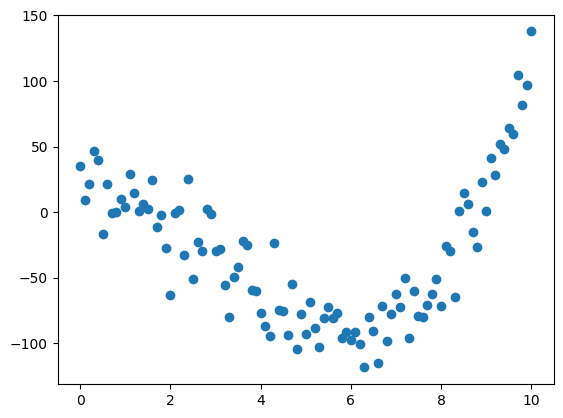

In [4]:
def get_poly_data(coef, x_start=0, x_fin=10, n=101, noise=20):
    np.random.seed(0)
    x = np.linspace(x_start, x_fin, n)
    y = poly(x, coef) 
    
    # add some noise
    y = y + np.random.standard_normal(x.size) * noise
    
    # reshape into sklearn standard (n_samples, n_features)
    x = x.reshape(-1, 1)
    return x, y

# y = 0 x^0 + 10 x^1 - 10 x^2 + 1 x^3
coef = [0, 10, -10, 1]

x, y = get_poly_data(coef)
plt.scatter(x, y);

## Creating the design matrix
### The columns of x features

In [5]:
from sklearn.preprocessing import PolynomialFeatures

x = np.linspace(0, 10, 101)
x = x.reshape(-1, 1)

In [6]:
# examine "raw" features
# right now, x is just an example feature with 101 values from 0 to 10
#x
x[18: 23]

array([[1.8],
       [1.9],
       [2. ],
       [2.1],
       [2.2]])

In [7]:
degree = 4
poly_feat = PolynomialFeatures(degree=degree)
x_poly = poly_feat.fit_transform(x)

# examine polynomial features
x_poly[18:23]

array([[ 1.    ,  1.8   ,  3.24  ,  5.832 , 10.4976],
       [ 1.    ,  1.9   ,  3.61  ,  6.859 , 13.0321],
       [ 1.    ,  2.    ,  4.    ,  8.    , 16.    ],
       [ 1.    ,  2.1   ,  4.41  ,  9.261 , 19.4481],
       [ 1.    ,  2.2   ,  4.84  , 10.648 , 23.4256]])

## Polynomial Regression: Putting it all together

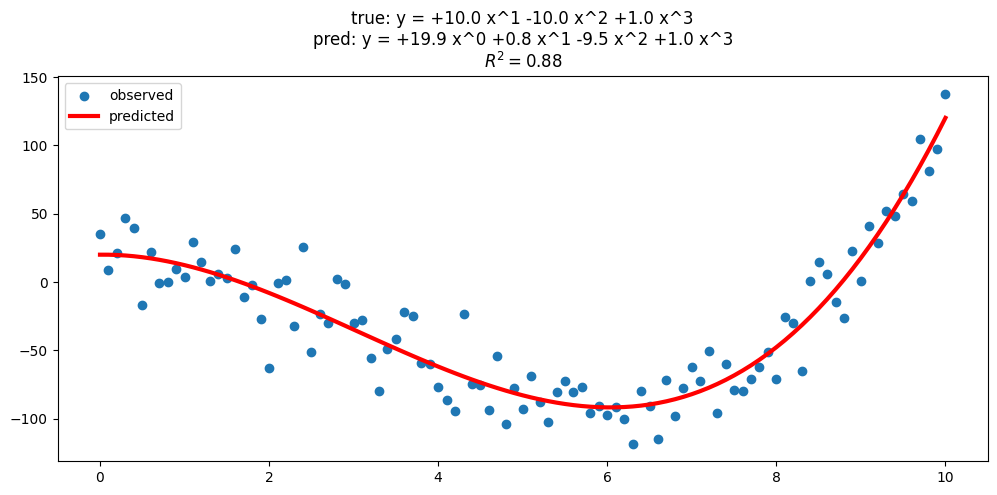

In [8]:
# y = 0 x^0 + 10 x^1 - 10 x^2 + 1 x^3
coef = [0, 10, -10, 1]

# in practice, we can't use the "right" answer (coef above) because we won't know exactly what the true degree is
# we'll revisit this later.  for now, we'll "cheat" by setting
# degree by peeking at proper answer
degree = len(coef) - 1

# get noisy polynomial data
x, y = get_poly_data(coef)

# process x to polynomial features
poly_feat = PolynomialFeatures(degree=degree)
x_poly = poly_feat.fit_transform(x)

# fit polynomial regression
# because our first x-feature is simply 1 we don't fit an intercept (the first coefficient will be the intercept)
reg = LinearRegression(fit_intercept=False)
reg.fit(x_poly, y)

# predict y (from regression)
y_pred = reg.predict(x_poly)

# plot
plt.scatter(x, y, label='observed')
plt.plot(x, y_pred, color='r', linewidth=3, label='predicted')

# collect coefficients
coef_pred = reg.coef_

# getting strs of polynomial (to print)
str_poly_true = coef_to_poly_str(coef)
str_poly_pred = coef_to_poly_str(coef_pred)

plt.title(f'true: {str_poly_true}\npred: {str_poly_pred}\n$R^2=${r2_score(y, y_pred):.2f}')

plt.legend()
plt.gcf().set_size_inches(12, 5)

In [9]:
def fit_plot_poly(x, y, degree):
    """ fits and plots a polynomial of given degree
    
    Args:
        x (np.array): (n_samples, 1) array of x inputs
        y (np.array): (n_sample, 1) array of target values
        degree (int): max degree of polynomial
    """
    
    # project x to polynomial
    poly_project = PolynomialFeatures(degree=degree)
    x_poly = poly_project.fit_transform(x)
    
    # fit via linear regression
    reg = LinearRegression(fit_intercept=False)
    reg.fit(x_poly, y)
    
    # predict y values (line of polynomial)
    # (we use 101 evenly spaced points as there may be so few
    # observations that the polynomial appears piecewise linear
    # with straight lines between each observation)
    x_fine = np.linspace(x.min(), x.max(), 101).reshape(-1, 1)
    x_fine_poly = poly_project.fit_transform(x_fine)
    y_pred_fine = reg.predict(x_fine_poly)
    
    # compute r2
    y_pred = reg.predict(x_poly)
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    # get the predicted line
    coef_pred = reg.coef_
    str_poly_pred = coef_to_poly_str(coef_pred)
    
    # plot polynomial / observations
    plt.plot(x_fine, y_pred_fine, label=f'degree {degree} fit', color='k', linewidth=2)
    plt.title(f'pred: {str_poly_pred}\n$R^2=${r2:.2f}')
    plt.scatter(x, y, label='observed', color='r')
    plt.legend()  
    
    return reg

LinearRegression(fit_intercept=False)

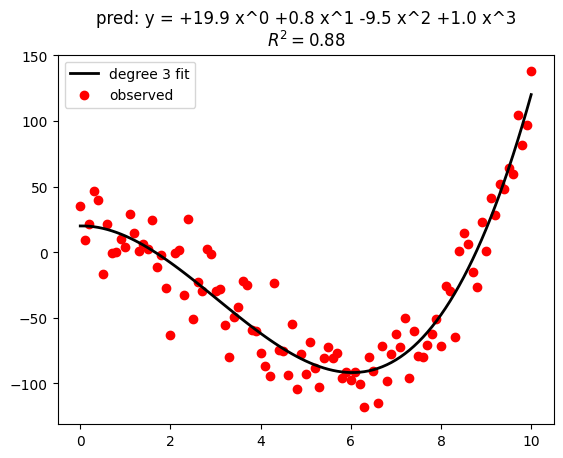

In [10]:
# get noisy polynomial data
x, y = get_poly_data(coef)

#fit_plot_poly(x, y, 0)
#fit_plot_poly(x, y, 1)
#fit_plot_poly(x, y, 2)
fit_plot_poly(x, y, 3)
#fit_plot_poly(x, y, 4)

## In a real problem how do we know what degree to choose?

In our dummy data we "cheated" by looking at the real polynomial, represented by `coef`, to determine what degree we should fit the polynomial with:

```python
# degree: what order polynomial should we fit data with?
degree = len(coef) - 1
```

In practice we won't have this luxury ...

### $R^2$ reminder:
- $R^2=1$ implies the line passes through each observation
- $R^2=0$ when the line "ignores" $x$ and is constant at `np.mean(y)`
    - see `degree=0` above
- $R^2<0$ implies the line does a poorer job than the constant estimate `np.mean(y)`
    - this should be very rare, and is only even possible in multiple/polynomial (not simple) regression

### A good first approach at choosing degree:

**Maybe choosing the polynomial with maximum $R^2$ is a good idea ...**

Spoiler Alert: its not a good idea

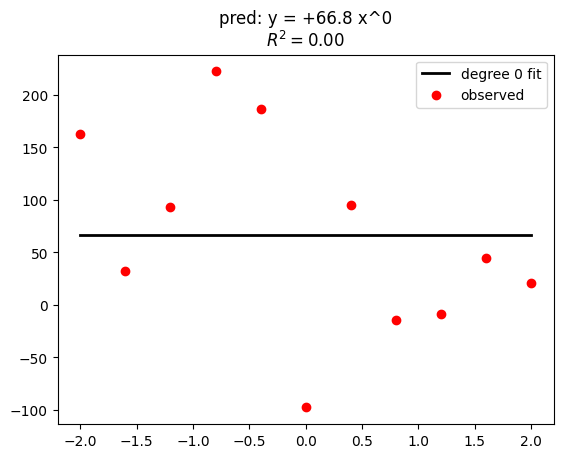

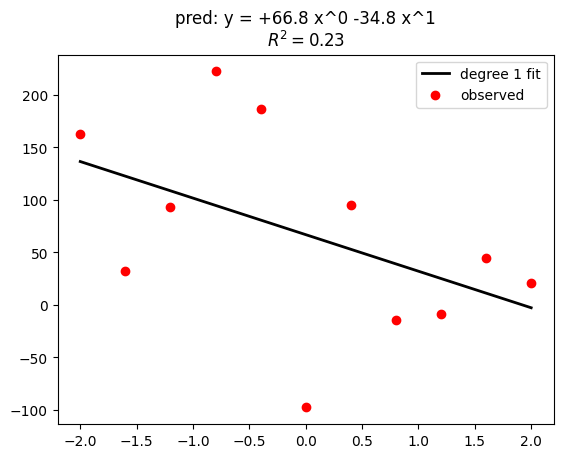

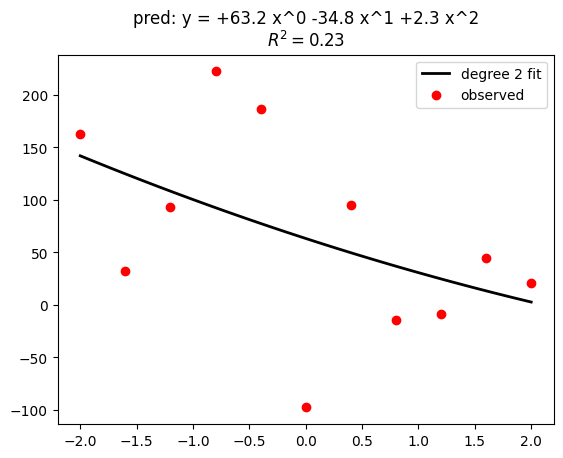

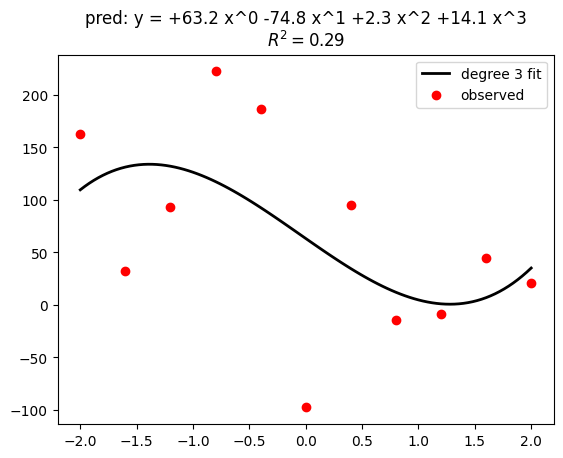

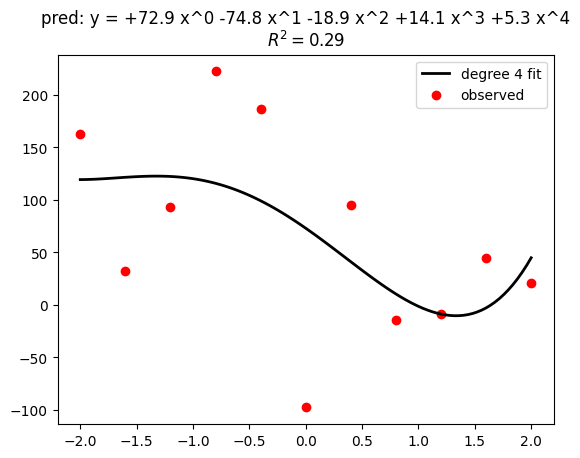

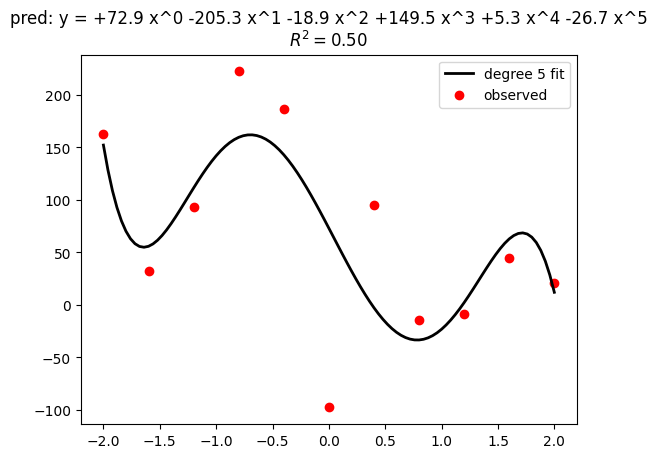

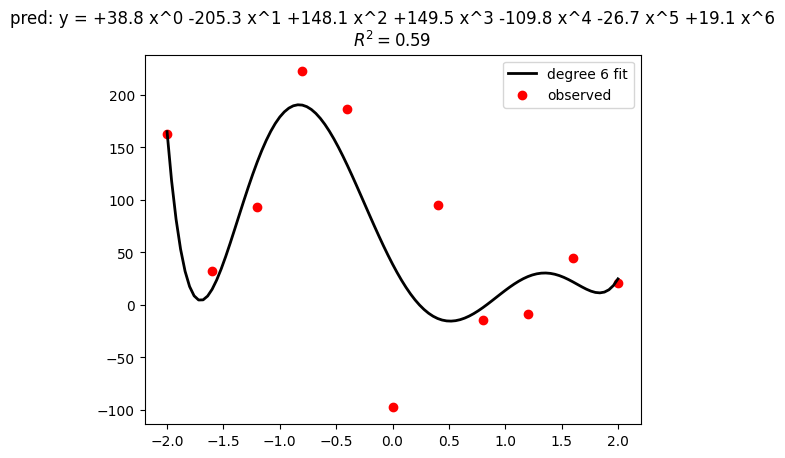

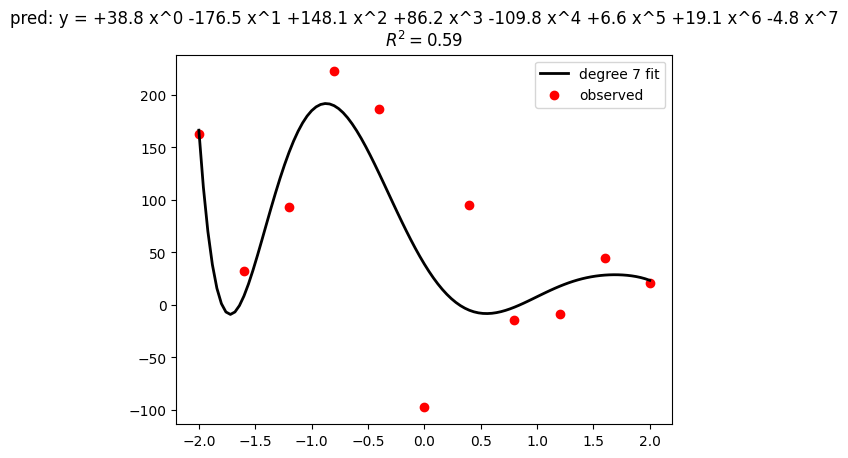

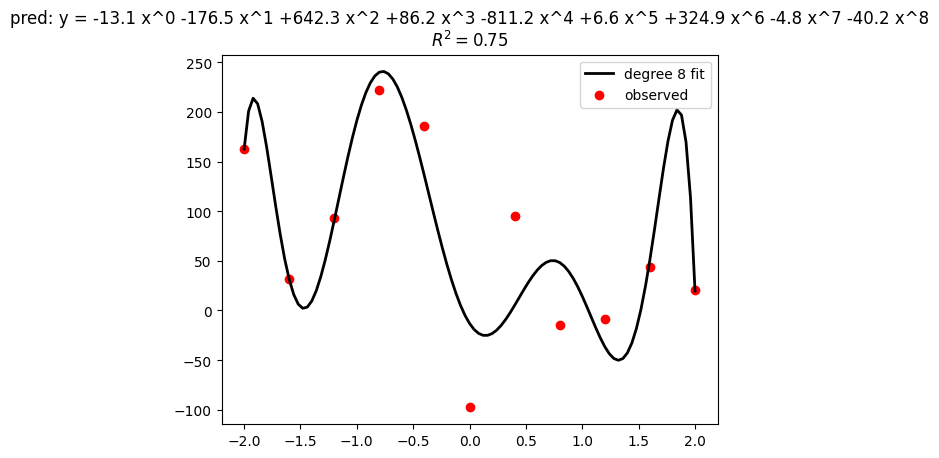

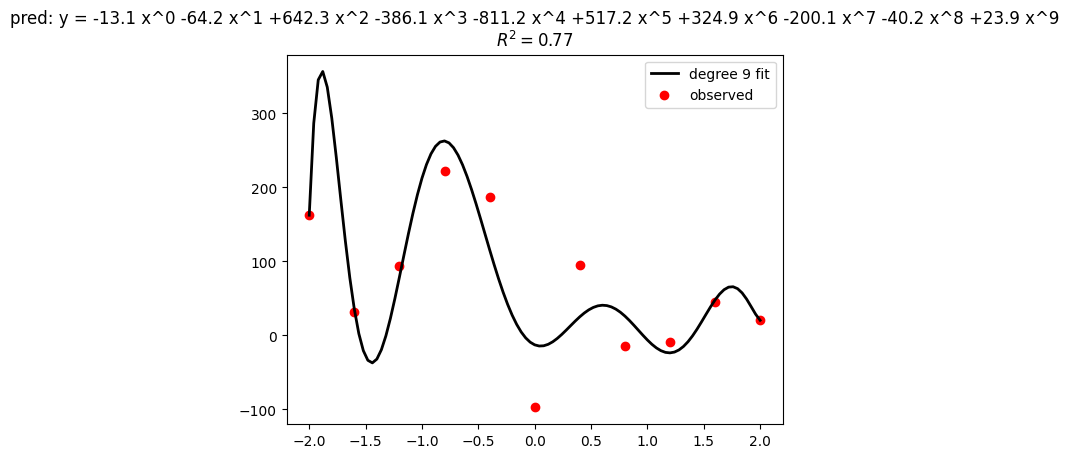

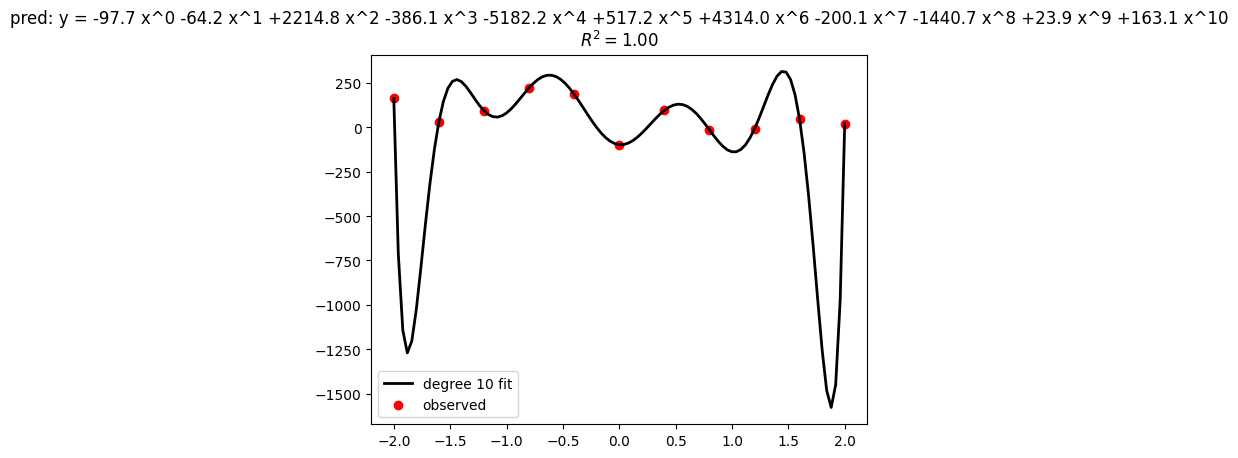

In [11]:
coef = np.array([0, 1, -1, 1])
noise_snr = 100

x, y = get_poly_data(coef, x_start=-2, x_fin=2, n=11, noise=noise_snr)

for degree in range(11):
    # we need a new figure with every plot (so they don't all plot on same figure!)
    plt.figure()

    fit_plot_poly(x, y, degree)

# Preventing overfitting:

|                          |                            Underfitting                            |                            Proper fitting                           |                            Overfitting                            |
|:------------------------:|:------------------------------------------------------------------:|:-------------------------------------------------------------------:|:-----------------------------------------------------------------:|
| Training Set Performance |                                 Bad                                |                                 Good                                |                              Too Good                             |
|  Testing Set Performance |                                 Bad                                |                            About as good                            |                                Bad                                |
|     Model Complexity     |                               Simple                               |                         balanced complexity                         |                           Overly complex                          |
|                          | <img src="https://i.ibb.co/sPTY37G/underfit-poly.png" width=250px> | <img src="https://i.ibb.co/HYGHxvm/justright-poly.png" width=250px> | <img src="https://i.ibb.co/sP76DKd/overfit-poly.png" width=250px> |

In many problems, we are building the classifier / regression model to predict new, unseen samples.  Given this:

**"proper fit" is the model which maximizes the performance on a testing set (e.g. cross validated accuracy or cross validated $R^2$)**

In [12]:
def cross_val_r2(x, y, degree, n_splits=10):
    """ computes cross validated r2 (regression performance on unseen data)
    
    """
    # project x to polynomial
    poly_project = PolynomialFeatures(degree=degree)
    x_poly = poly_project.fit_transform(x)
        
    # initialize empty y predictions
    y_pred = np.empty_like(y)
    
    # initialize linear regression model
    # fit_intercept=False since we're using poly features
    reg = LinearRegression(fit_intercept=False)
    
    kfold = KFold(n_splits=n_splits)
    for train_idx, test_idx in kfold.split(x_poly, y):
        # split data
        x_poly_test = x_poly[test_idx, :]
        x_poly_train = x_poly[train_idx, :]
        y_train = y[train_idx]
        
        # fit
        reg.fit(x_poly_train, y_train)
        
        # predict
        y_pred[test_idx] = reg.predict(x_poly_test)
        
    # compute cross validated r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    return r2

LinearRegression(fit_intercept=False)

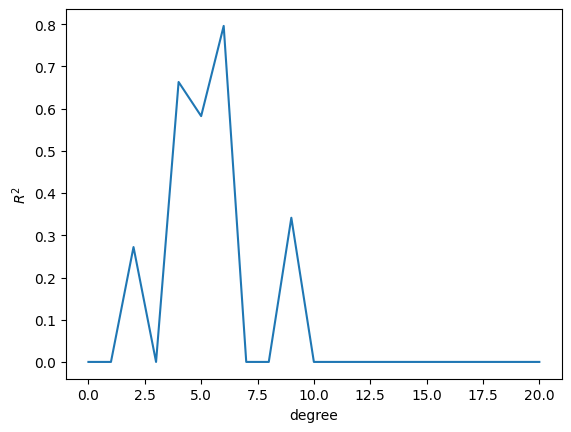

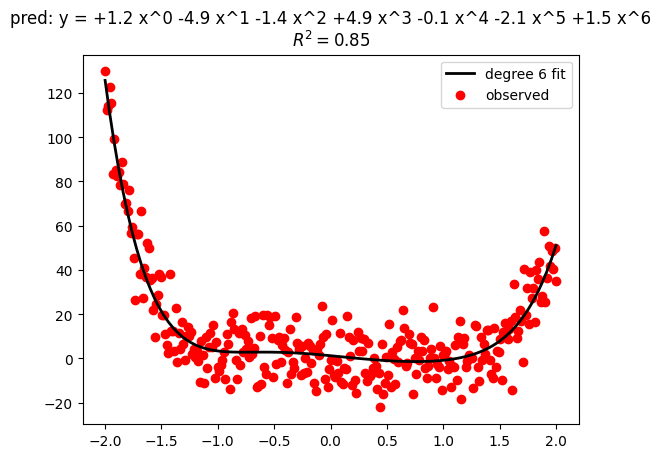

In [13]:
coef = np.array([0, 0, 0, 0, 1, -1, 1])
noise_snr = 10

# sample noisy data from polynomial
x, y = get_poly_data(coef, x_start=-2, x_fin=2, n=301, noise=noise_snr)

# estimate cv r2 per degree of polynomial
r2_per_degree = list()
for degree in range(21):
    r2 = cross_val_r2(x, y, degree)
    r2_per_degree.append(r2)
    
r2_per_degree = np.maximum(np.array(r2_per_degree), 0)
# r2_per_degree = np.array(r2_per_degree)

    
plt.plot(r2_per_degree)
plt.xlabel('degree')
plt.ylabel(f'$R^2$')

plt.figure()
degree_best = np.argmax(r2_per_degree)
fit_plot_poly(x, y, degree_best)

## With EV Data

In our initial fit with `Acceleration` predicting `Top Speed` one of the error plots suggested that the relationship might not be linear:

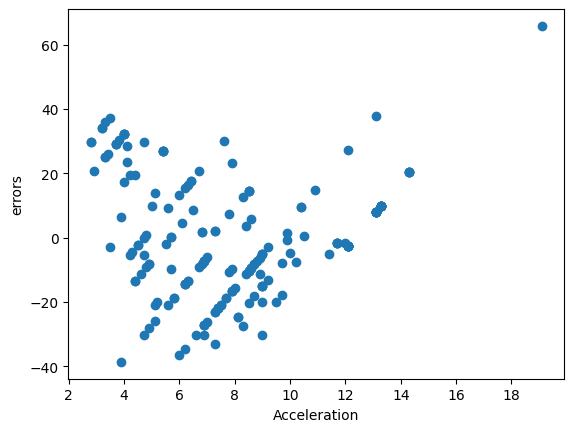

In [14]:
df_ev = pd.read_csv('evdataset.csv')

x = np.array(df_ev['Acceleration']).reshape(-1, 1)
y = np.array(df_ev['Top Speed'])

reg = LinearRegression()

reg.fit(x, y) 

y_pred = reg.predict(x)

errors = y - y_pred

plt.scatter(x = x, y = errors)
plt.xlabel('Acceleration')
plt.ylabel('errors');

Because of this, we might see if Polynomial Regression is more appropriate:

LinearRegression(fit_intercept=False)

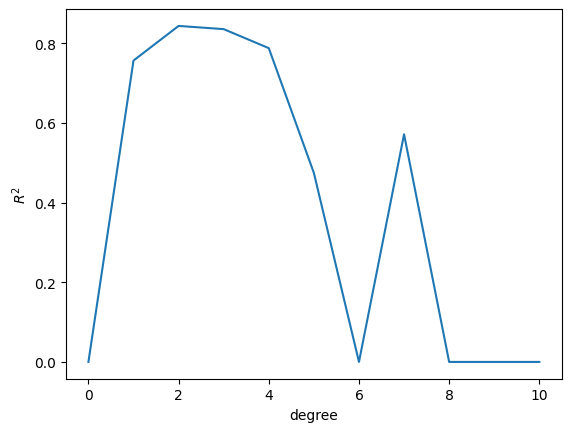

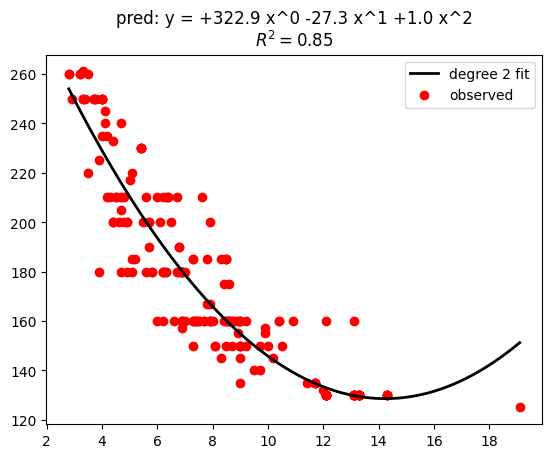

In [15]:
# estimate cv r2 per degree of polynomial
r2_per_degree = list()
for degree in range(11):
    r2 = cross_val_r2(x, y, degree)
    r2_per_degree.append(r2)
    
r2_per_degree = np.maximum(np.array(r2_per_degree), 0)

plt.plot(r2_per_degree)
plt.xlabel('degree')
plt.ylabel(f'$R^2$')

plt.figure()
degree_best = np.argmax(r2_per_degree)
fit_plot_poly(x, y, degree_best)

We can get errors the same way with a polynomial fit, and check to see that the pattern we saw in the error plot is gone (i.e. that we've "fixed" the constant variance assumption:

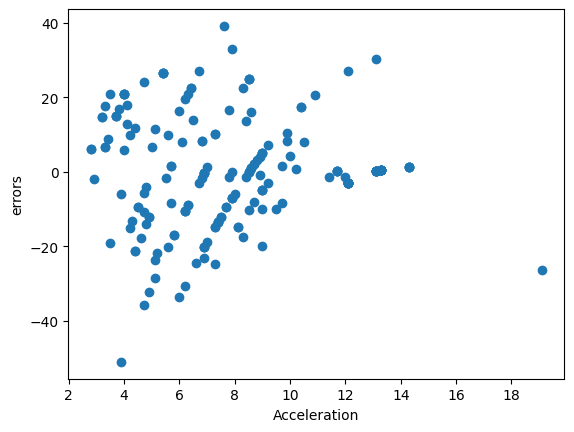

In [16]:
# project x to polynomial (degree 2 seems best from above)
poly_project = PolynomialFeatures(degree=2)
x_poly = poly_project.fit_transform(x)
    
# fit via linear regression
reg = LinearRegression(fit_intercept=False)
reg.fit(x_poly, y)

y_pred = reg.predict(x_poly)

errors = y - y_pred

plt.scatter(x = x, y = errors)
plt.xlabel('Acceleration')
plt.ylabel('errors');

# Lecture Break/Practice 1

For the `hank_aaron_hr.csv` dataset
1. regress `age` & `HRR`
    - this gives baseball player Hank Aarons Home Run Rate over his career by age
1. use cross validation to find the best polynomial fit for the model (test degree `0` through `10`)
    - use `n_splits=23` (this will use each point as its own fold; a reasonable approach when you have a very small data set)
1. plot the best fit line over the points for that polynomial fit of all the data and calculate the $R^2$
1. check the assumptions (independence, constant variance, and normality)

In [17]:
df_aaron = pd.read_csv('hank_aaron_hr.csv')
df_aaron.head()

,Unnamed: 0,playerID,age,AB,HR,HRR
0,10,aaronha01,26,590,40,0.067797
1,11,aaronha01,31,570,32,0.056140
2,12,aaronha01,20,468,13,0.027778
3,13,aaronha01,27,603,34,0.056385
4,14,aaronha01,34,606,29,0.047855


# K-means and Clustering


|                          | Input Features per sample | Output Features per sample | Supervised | Penguin Example                                                                       |
|:------------------------:|:-------------------------:|:--------------------------:|:----------:|---------------------------------------------------------------------------------------|
|           Classification | 1+ numerical features     | one categorical feature    | True       | Given `body_weight_g`, `flipper_length_mm` estimate `species`                         |
|               Regression | 1+ numerical features     | one continuous feature     | True       | Given `body_weight_g`, `bill_depth_mm` estimate `flipper_length_mm`                   |
|               Clustering | 1+ numerical features     | one categorical feature    | False      | Identify k groups of penguins which have similar `body_weight_g`, `flipper_length_mm` |
| Dimensionality Reduction | N numerical features      | < N numerical features     | False      | Find 2d vector which best represents all 4 of penguin's body/flipper/beak features    |

## What does Clustering do?

It identifies sub-groups within a population.

It doesn't necessarily find the sub-groups with some particular application meaning (e.g. penguin species below)

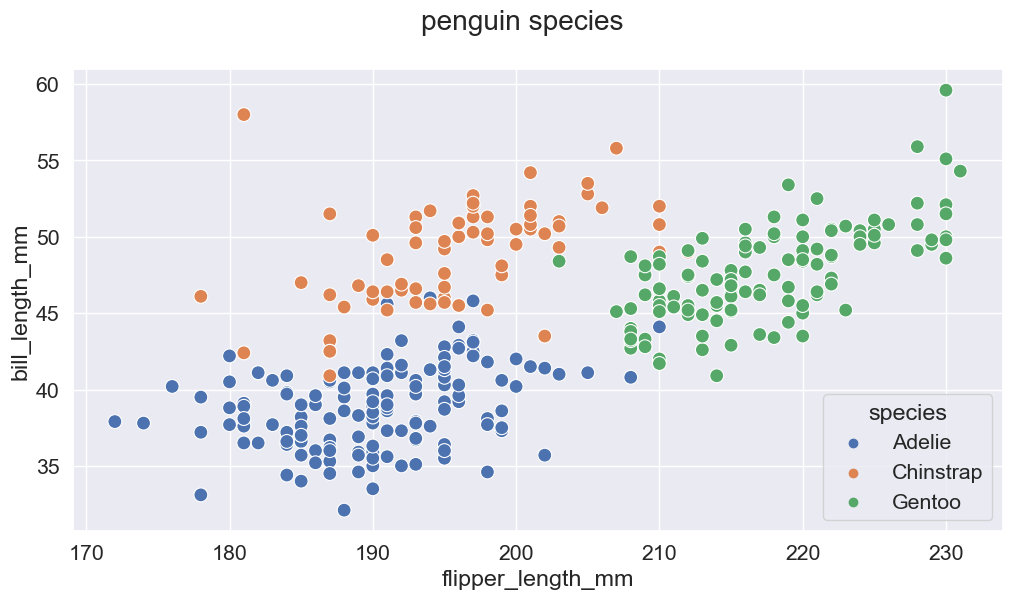

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df_penguin = sns.load_dataset('penguins')

df_penguin.dropna(axis=0, how='any', inplace=True)

sns.set(font_scale=1.4)

# 
sns.scatterplot(data=df_penguin, x='flipper_length_mm', y='bill_length_mm', hue='species', s=100)
plt.gcf().set_size_inches(12, 6)
plt.suptitle('penguin species');

Text(0.5, 0.98, 'penguins (what is their subgroups membership?)')

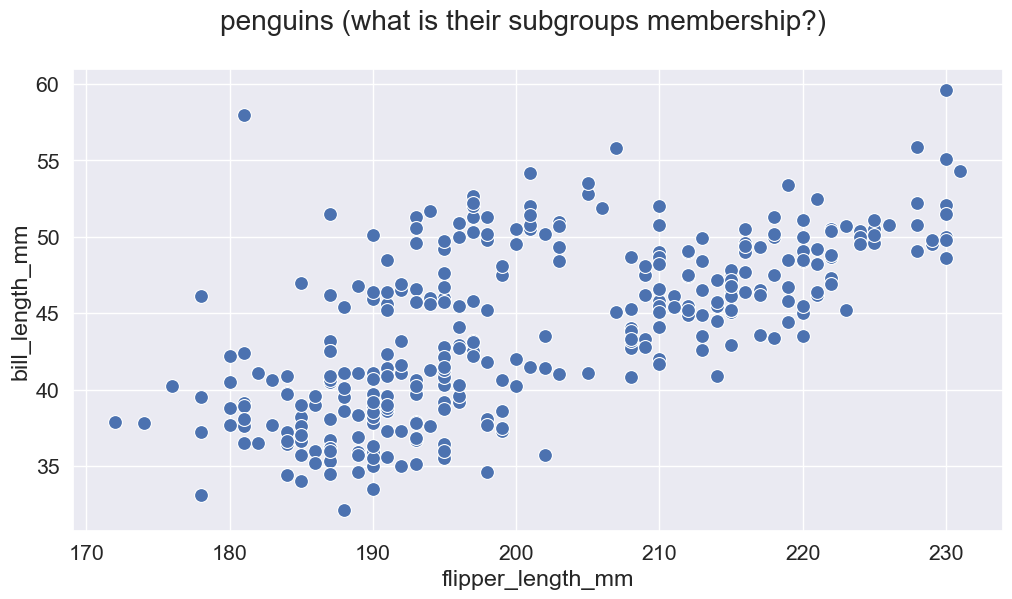

In [19]:
sns.scatterplot(data=df_penguin, x='flipper_length_mm', y='bill_length_mm', s=100)
plt.gcf().set_size_inches(12, 6)
plt.suptitle('penguins (what is their subgroups membership?)')

## Clustering examples:
Clustering partitions a set of samples into clusters with similar characteristics:

- **Disease characterization**
    - Given a population of clinical features of people with Schizophrenia:
        - severeity of symptoms
        - clinical scores
            - physical, emotional, cognitive symptoms
        - brain imaging
        - disease progression
            - age onset
    - Maybe we can identify k distinct sub-types of "Schizophrenia".  (Is it really one disease or maybe it is many diseases which science cannot yet distinguish?)
    
- **Network Analysis**
    - Given a measure of distance between users in a social network:
        - number of messages between each pair of users
    - can we identify cliques?
        - clique: subgroups of people who often communicate with each other
    
- **Email filtering**
    - Given features about email
        - domain of sender
        - user response time
        - keyword inclusion
            - ✔️𝐀𝐂𝐓 𝐍𝐎𝐖, 𝖦𝖾𝗍 $𝟤𝟧𝟢,𝟢𝟢𝟢 𝗈𝖿 𝖳𝖾𝗋𝗆 𝖫𝗂𝖿𝖾 𝖢𝗈𝗏𝖾𝗋𝖺𝗀𝖾 𝖺𝗌 𝗅𝗈𝗐 𝖺𝗌 $𝟣𝟧/𝖬𝗈👀
    - Can we identify subgroups of email to automatically sort them for users?
        - personal email
        - professional email
        - spam
        - some other group of emails which is user specific

- **Athlete Types**
    - Given features about players of a sport/athletes:
        - height, weight, handedness, position
        - performance in the sport
    - Can we identify subgroups of similar players?
        - scorers
        - defenders
        - clutch players
        - supporting players

## Difference between Clustering and Classification

In classification:
 - **we know the groups and are trying to predict if an observation belongs to a specific group**
 
In clustering:
 - **we do not know what sort of groups there may or may not be, but wish to determine which observations are similar to each other (which ones form clusters)**

# K-Means Clustering

Approach:
- alternate between:
    - pick cluster centers (centroids) as the average of all samples in each cluster
    - assign each sample to the closest cluster centroid

## Demo 1
Shows each step above seperately: 

https://www.naftaliharris.com/blog/visualizing-k-means-clustering/
 
## Demo 2
Nicer data / interactivity:

https://user.ceng.metu.edu.tr/~akifakkus/courses/ceng574/k-means/

# K-Means Clustering (detail)

### Approach:
- alternate between:
    - pick cluster centers as the average of all samples in each cluster
    - assign each sample to the closest cluster center
    
### Q1: How do I pick the initial centroids?
Either:
- randomly
- pick the k-th cluster centroid as the furthest sample from first k-1 centroids

### Q2: How do you measure if your clustering did a good job?

### Q3: Will K-Means eventually stop iterating?

### Q4: How do I pick a K which is best for my data?

# Q2: How do we measure how good the clustering is?

Bad clustering (lines from samples to centroids are long)
<img src="https://i.ibb.co/Qj6sxVz/cluster-bad.png" width=300px>

Good clustering (lines from samples to centroids are short)
<img src="https://i.ibb.co/2gmCmcV/cluster-good.png" width=300px>

A good clustering gives centroids which are close to each of the samples which belong to its cluster.

We can quantify the quality of a clustering by computing the average line length (squared distance from each sample to its centroid):

$$\frac{1}{N} \sum_i \sum_{x_j \in i} ||x_j - c_i||^2 $$

where $N$ is the number of observations, $c_i$ is the cluster centroid of cluster $i$ and $x_j \in i$ are all the samples $x_j$ which are in cluster $i$.

# Q3: Will K-Means Clustering eventually stop iterating?

Yes, its garaunteed to!

### Definition:

**"Clustering"**: a particular assignment of samples to k sub-groups

#### Proof Sketch:

##### Idea 1: We'll never return to a particular clustering as we update
K-means approach:
- alternate between:
    - pick cluster centers as the average of all samples in each cluster
        - **this moves cluster centers closer, on average, to the points in their cluster**
    - assign each sample to the closest cluster center
        - **this moves cluster centers closer, on average, to the points in their cluster**

##### Idea 2: There is a finite amount of clusterings 
$N^k$ for $N$ samples and $k$ clusters

##### Putting it together:
Given we can't repeat any of the clusterings, we'll eventually run out and K-means will stop.

## K-means: implementation

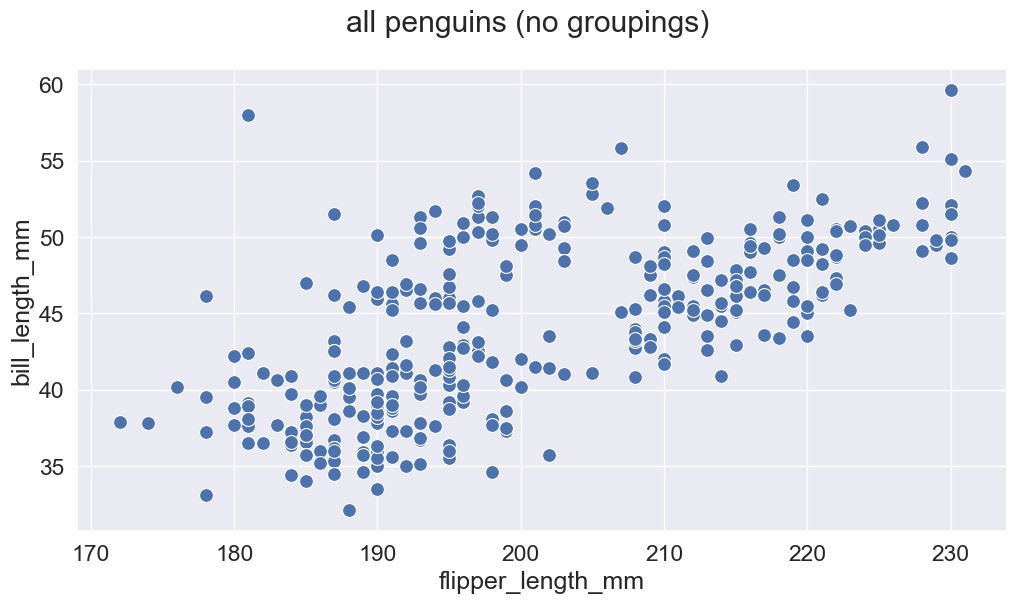

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)

df_penguin = sns.load_dataset('penguins')
df_penguin.dropna(axis=0, how='any', inplace=True)

sns.scatterplot(data=df_penguin, x='flipper_length_mm', y='bill_length_mm', s=100)
plt.gcf().set_size_inches(12, 6)
plt.suptitle('all penguins (no groupings)');

Text(0.5, 0.98, 'clusters of penguins (similar features)')

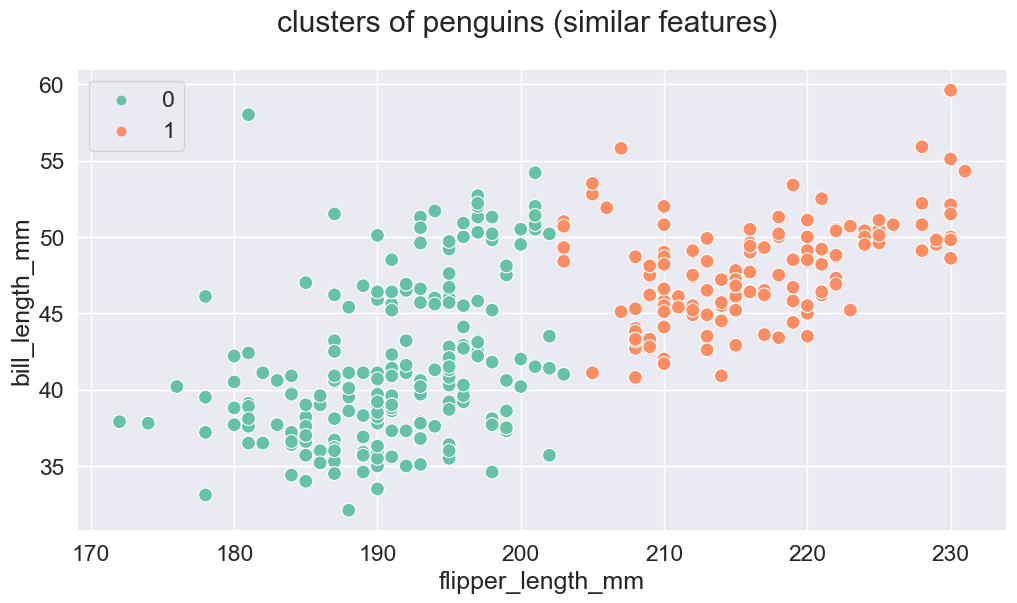

In [21]:
from sklearn.cluster import KMeans

n_clusters = 2
#n_clusters = 3
#n_clusters = 4

x_feat_list = ['flipper_length_mm', 'bill_length_mm']
x = df_penguin.loc[:, x_feat_list].values

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(x)
y = kmeans.predict(x)

sns.scatterplot(data=df_penguin, x='flipper_length_mm', y='bill_length_mm', s=100, hue=y, palette='Set2')
plt.gcf().set_size_inches(12, 6)
plt.suptitle('clusters of penguins (similar features)')

Text(0.5, 0.98, 'actual species of penguins')

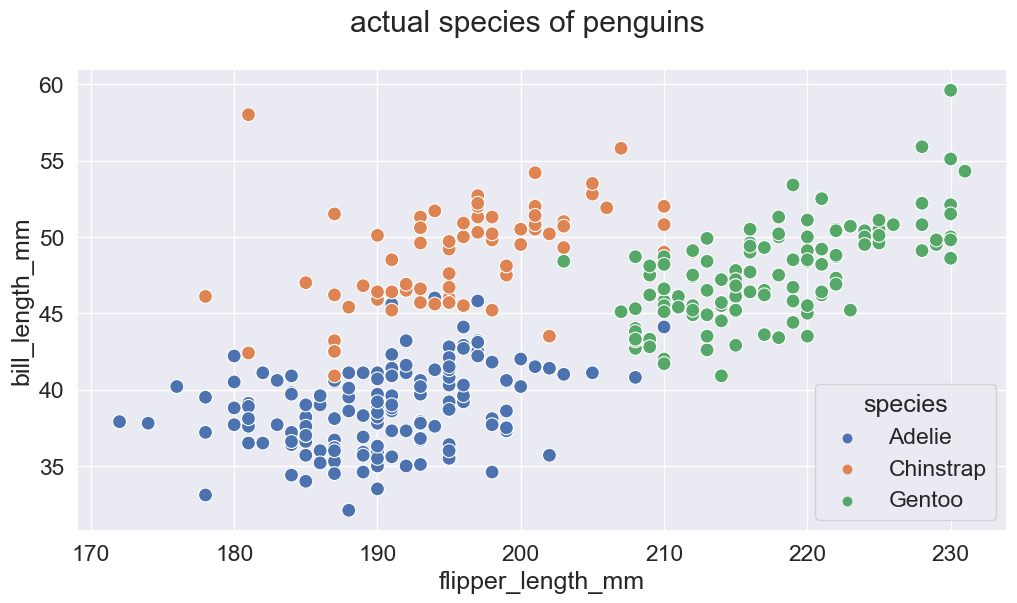

In [22]:
sns.scatterplot(data=df_penguin, x='flipper_length_mm', y='bill_length_mm', hue='species', s=100)
plt.gcf().set_size_inches(12, 6)
plt.suptitle('actual species of penguins')

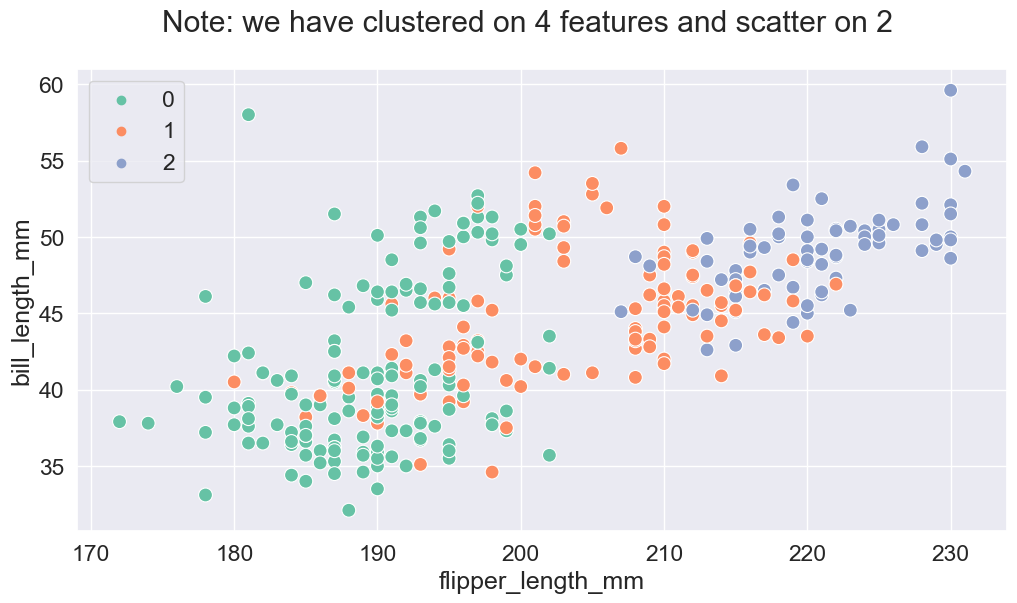

In [23]:
from sklearn.cluster import KMeans

n_clusters = 3

# note: we add all 4 features in
x_feat_list = ['flipper_length_mm', 'bill_length_mm', 'bill_depth_mm', 'body_mass_g']
x = df_penguin.loc[:, x_feat_list].values

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(x)
y = kmeans.predict(x)

sns.scatterplot(data=df_penguin, x='flipper_length_mm', y='bill_length_mm', s=100, hue=y, palette='Set2')
plt.gcf().set_size_inches(12, 6)

plt.suptitle('Note: we have clustered on 4 features and scatter on 2');

### Q4: How do I pick a K which is best for my data?

### There is no canonical "right" answer
We can't use Cross Validation in clustering as we don't have access to any ground truth $y$ ... by definition there is no "correct" clustering! In fact, because we know the Species of a penguin, it doesn't make sense to use clustering, we should use classification. What clustering does is tell us: based on the features provided, and the number of clusters, here are the observations which are similar to each other.
    
### How does changing k impact how "good" a clustering is?
Let's observe how our clustering metric changes as $k$ increases:

$$\frac{1}{N} \sum_i \sum_{x_j \in i} ||x_j - c_i||^2 $$

which can be computed via `sklearn` as:

```python
    # kmeans.score() gets the negative mean distance to centroid
    mean_d = -kmeans.score(x)
```


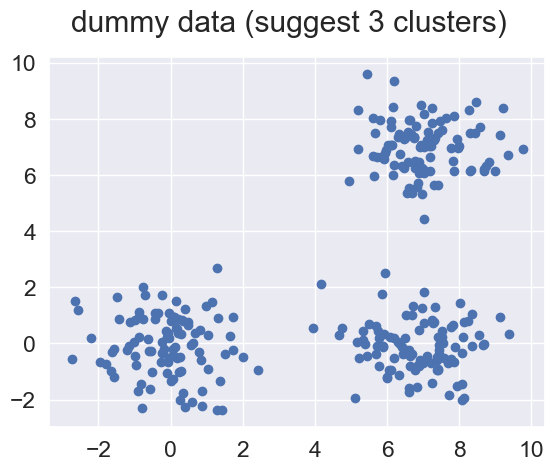

In [24]:
import numpy as np

# we generate dummy data with clean clusters (penguins don't have super clean clusterings)
x = np.vstack([np.random.multivariate_normal(mean=[0, 0], cov=np.eye(2), size=100),
               np.random.multivariate_normal(mean=[7, 0], cov=np.eye(2), size=100),
               np.random.multivariate_normal(mean=[7, 7], cov=np.eye(2), size=100)])

plt.scatter(x[:, 0], x[:, 1])
plt.suptitle('dummy data (suggest 3 clusters)');

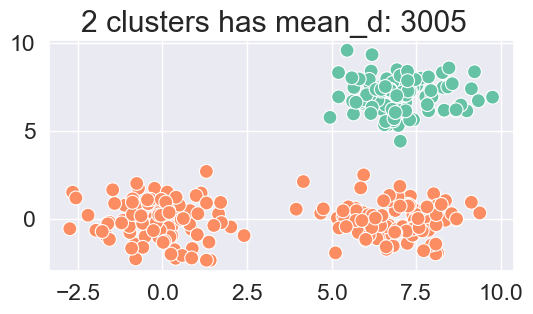

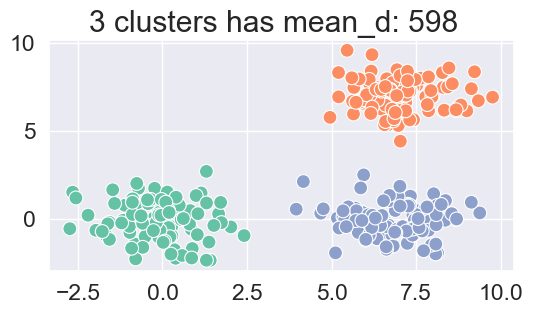

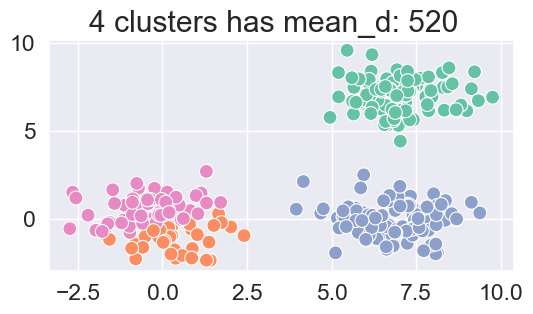

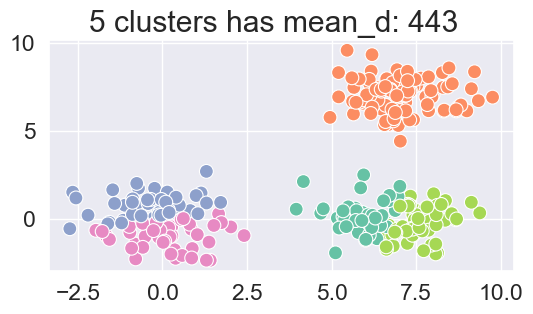

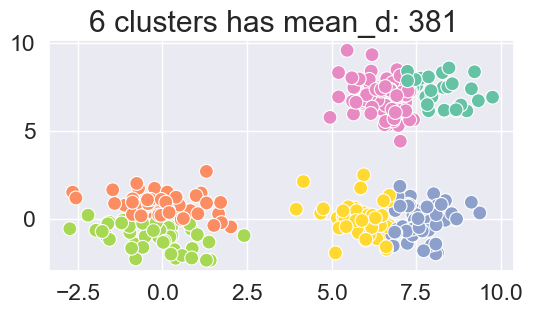

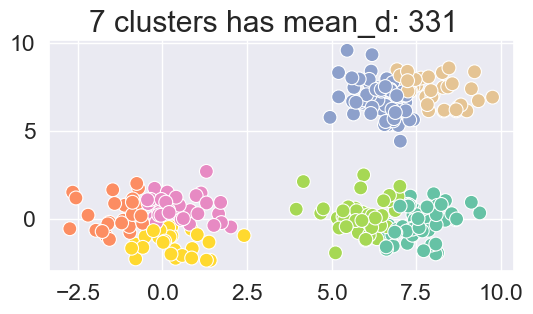

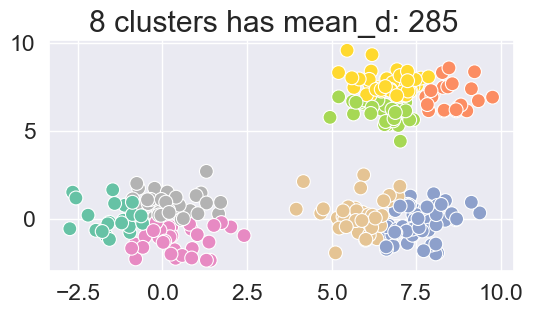

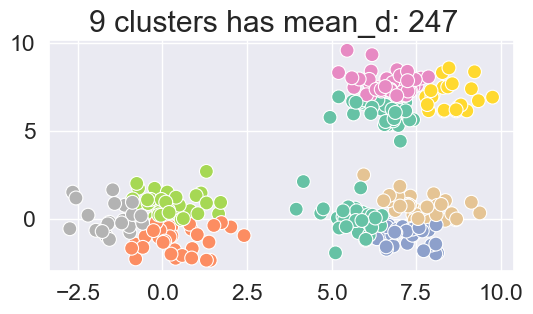

In [25]:
from sklearn.cluster import KMeans

# keys are k (number of clusters), values are mean_d (mean distance
# from each sample to its cluster centroid)
mean_d_dict = dict()
for n_clusters in range(2, 10):
    # fit kmeans
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    y = kmeans.predict(x)    
        
    # compute & store mean distance
    mean_d = -kmeans.score(x)
    mean_d_dict[n_clusters] = mean_d

    # plot clustering
    plt.figure()
    sns.scatterplot(x=x[:, 0], y=x[:, 1], s=100, hue=y, palette='Set2')
    plt.suptitle(f'{n_clusters} clusters has mean_d: {mean_d:.0f}')
    plt.gca().get_legend().remove()
    plt.gcf().set_size_inches(6, 3)
    

In [26]:
mean_d_dict

{2: 3004.699704644336,
 3: 598.2810308730182,
 4: 519.5315801610279,
 5: 443.2730097537397,
 6: 381.32492796099706,
 7: 331.24464106337865,
 8: 285.060378057536,
 9: 247.20913505890258}

### Bad News:
As k increases, our mean-distance-to-centroid metric will never get bigger ... we can't just choose the k which minimizes it!

# So how do I choose k then?

    “Everything should be made as simple as possible, but no simpler.” -Einsten ... sort of
    
He actually said [this](https://www.nature.com/articles/d41586-018-05004-4#:~:text=%E2%80%9CEverything%20should%20be%20made%20as,possible%20without%20having%20to%20surrender), but the gist is what's important. How does this help guide us?

"Simple as possible":

- fewest clusters

"No simpler":

- centroids should be close to their samples

Text(0, 0.5, 'mean dist^2 to centroid')

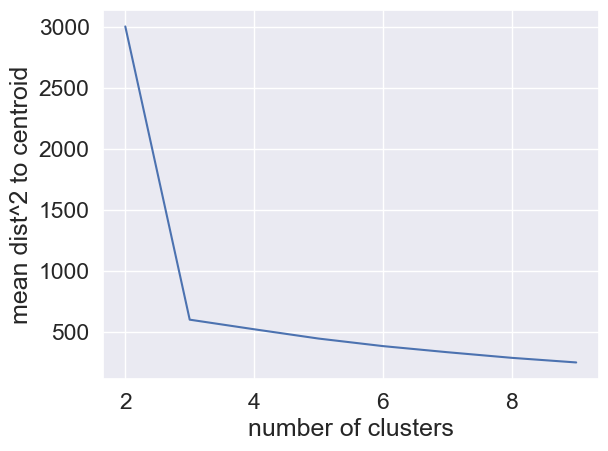

In [27]:
plt.plot(mean_d_dict.keys(), mean_d_dict.values())
plt.xlabel('number of clusters')
plt.ylabel('mean dist^2 to centroid')

3 clusters seems to have a good balance of simplicitiy (few clusters) while also ensuring centroids are close to their corresponding centroids.

This example was cooked up to have a beautiful "elbow" point at 3 clusters.  In practice, you may find yourself making an even more subjective decision.  Be rigorous where you can and when you must be subjective, be sure to have a good story / graph handy to explain why your guess is "best".

# Lecture Break/Practice 2

1. Download and use the `really_final_gtky.csv` data set from Canvas and run the below code to read it into python
2. Create a copy of the data frame called `df_gtky_scaled` where you scale normalize the three numeric variables (`prog_exp`, `age`, `start_sal`)
    - Keep the original `df_gtky` for later
3. Using all features except for `student_id`, `class` and `datetimestamp`, run the K-means algorithm for choices of $k$ from 2 to 15. Keep track of the mean-distance and then plot it to find the "elbow" and determine the best choice of $k$.
4. Run the K-means algorithm with your chosen $k$, then add a new column to the original `df_gtky` data frame called `cluster` which has the cluster assignments.
5. Examine the subgroups/clusters in the data and determine what similarities (if any) there are in the specified subgroups.

In [28]:
df_gtky = pd.read_csv("really_final_gtky.csv")
df_gtky.dropna(inplace=True)
df_gtky.head()

,student_id,class,co-op,prog_exp,age,start_sal,datetimestamp,python,java,r,c/c++,other(s)
0,bf82e6,Sophomore,False,9,234.0,60.0,2022-09-09 15:37:00,True,False,False,False,True
1,d0aece,Sophomore,False,7,233.0,100.0,2022-09-09 16:01:00,True,False,False,False,False
2,d23aab,Junior,True,7,252.0,70.0,2022-09-09 14:19:00,True,True,False,True,False
3,462311,Junior,False,7,243.0,50.0,2022-09-09 16:07:00,True,True,False,False,False
4,98ad06,Sophomore,False,5,231.0,90.0,2022-09-09 16:06:00,True,False,True,False,False
